[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ClimateMatchAcademy/course-content/blob/main/tutorials/W2D4_ClimateResponse-Extremes&Variability/W2D4_Tutorial7.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/{ORG}/course-content/main/tutorials/W2D4_ClimateResponse-Extremes&Variability/W2D4_Tutorial7.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# **Tutorial 7: Non-Stationarity in the EVT-framework**

**Week 2, Day 4, Extremes & Vulnerability**

**Content creators:** Matthias Aengenheyster, Joeri Reinders

**Content reviewers:** Younkap Nina Duplex, Sloane Garelick, Zahra Khodakaramimaghsoud, Peter Ohue, Laura Paccini, Jenna Pearson, Agustina Pesce, Derick Temfack, Peizhen Yang, Cheng Zhang, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google DeepMind

# **Tutorial Objectives**

In this tutorial, we will enhance our GEV model by incorporating non-stationarity to achieve a better fit for the sea surface height data from Washington DC we analyzed previously.

By the end of the tutorial you will be able to:
- Apply a GEV distribution to a non-stationary record by including a time-dependent parameter.
- Compare and analyze the fits of various models with different time-dependent parameters (e.g., location, scale, or shape).
- Calculate effective return levels using our non-stationary GEV model.


# **Setup**

In [1]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()

In [2]:
# #install dependencies - taken from <Yosmely Bermúdez> comments for Tutorial 6
# # We need this to install eigen which is needed for SDFC to install correctly
# !mamba install eigen numpy matplotlib seaborn pandas cartopy scipy texttable intake xarrayutils xmip cf_xarray intake-esm
# !pip install -v https://github.com/yrobink/SDFC/archive/master.zip#subdirectory=python
# !pip install https://github.com/njleach/mystatsfunctions/archive/master.zip

In [3]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.stats import genextreme as gev

import gev_functions as gf
import extremes_functions as ef
import SDFC as sd
import pooch
import os
import tempfile

Note that `import gev_functions as gf` imports the functions introduced in Tutorial 6.

In [4]:
# @title Helper functions
def estimate_return_level(quantile,model):
    loc, scale, shape = model.loc, model.scale, model.shape
    level = loc - scale / shape * (1 - (-np.log(quantile))**(-shape))
    return level

In [5]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

In [6]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

In [7]:
# helper functions

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/tutorials/W2D4_ClimateResponse-Extremes&Variability' # this is different for each day
    user_temp_cache=tempfile.gettempdir()
    
    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file

# **Section 1: Download and Explore the Data**
As before, we start by visually inspecting the data. Create a plot of the recorded data over time.

In [8]:
#fname = 'WashingtonDCSSH1930-2022.csv'
filename_WashingtonDCSSH1='WashingtonDCSSH1930-2022.csv'
url_WashingtonDCSSH1 = "https://osf.io/4zynp/download"
data = pd.read_csv(pooch_load(url_WashingtonDCSSH1,filename_WashingtonDCSSH1), index_col=0).set_index('years')

<Axes: xlabel='Annual Maximum Sea Surface \nHeight Anomaly (mm)', ylabel='Year'>

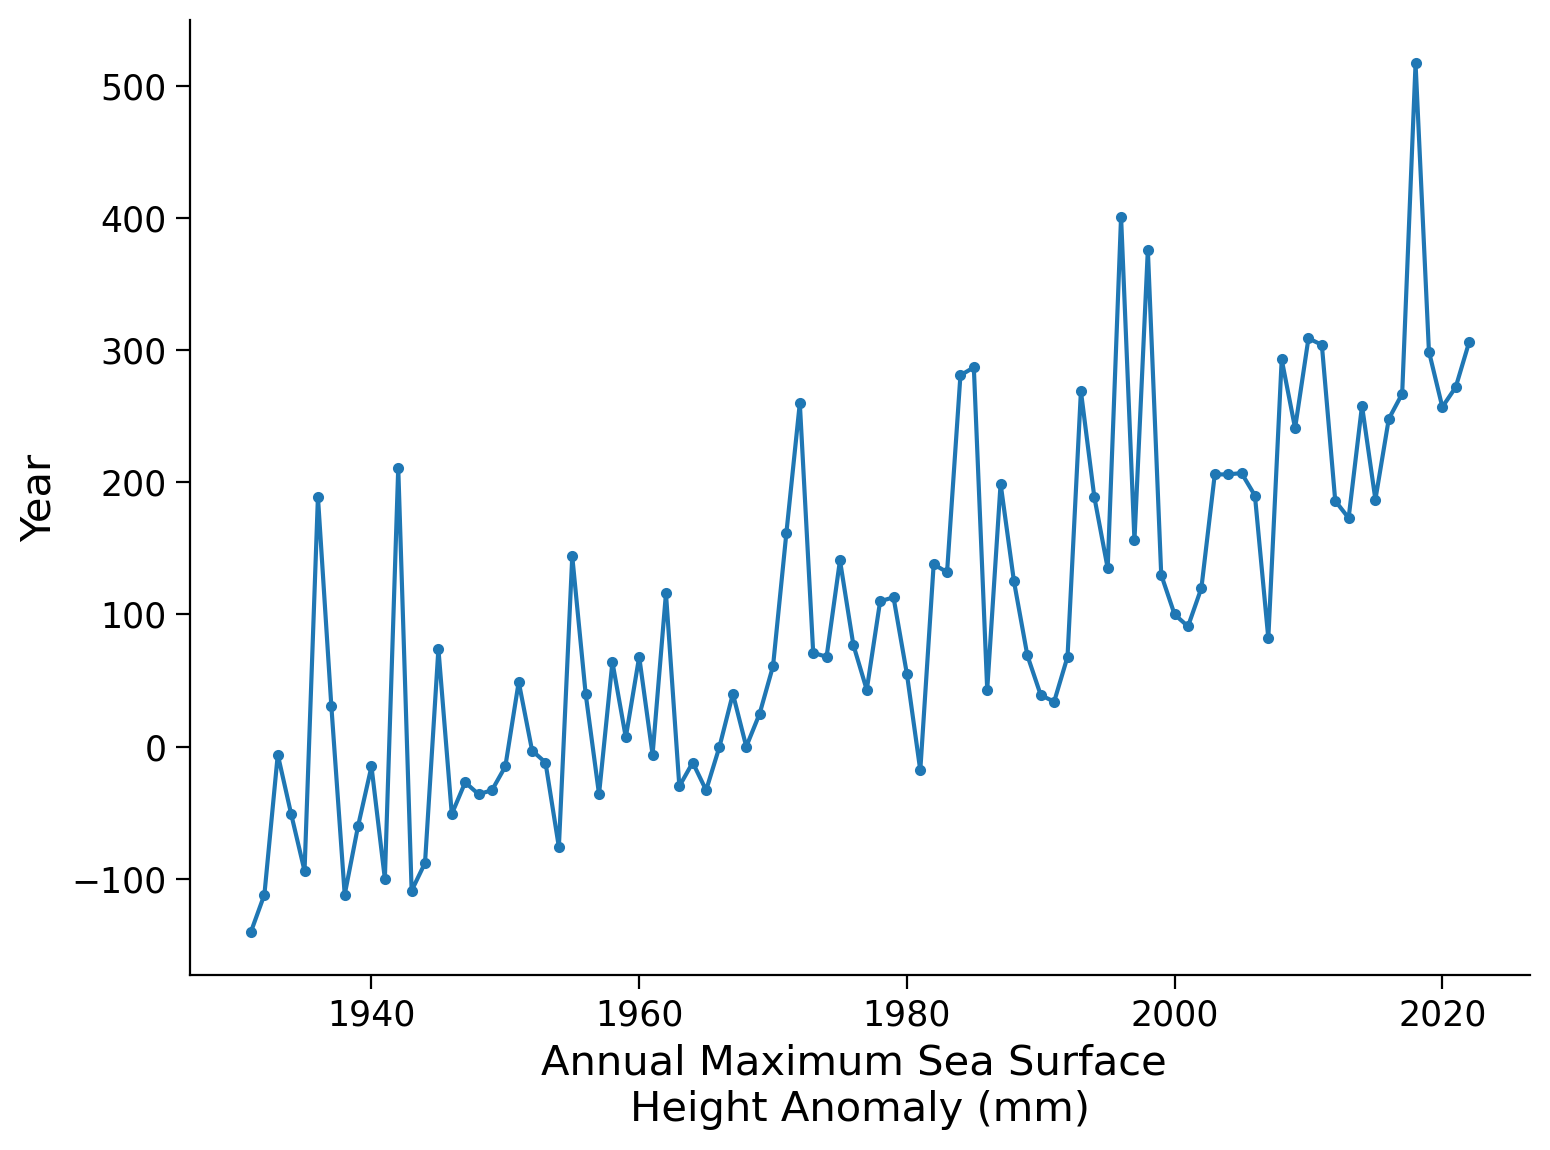

In [9]:
data.ssh.plot(linestyle='-',marker='.',xlabel='Annual Maximum Sea Surface \nHeight Anomaly (mm)',ylabel='Year')

Also, fit a stationary GEV distribution to the data and print the resulting fit:

In [10]:
shape, loc, scale = gev.fit(data.ssh.values,0)
fit = gf.fit_return_levels(data.ssh.values, years = np.arange(1.1,1000),N_boot=100)

Location: 4.5e+01, scale: 1.2e+02, shape: 1.2e-01
Ranges with alpha=0.050 :
Location: [16.68 , 71.49]
Scale: [99.17 , 133.71]
Shape: [-0.03 , 0.36]


In [11]:
print('Location: %.2f, Scale: %.2f, Shape: %.2f' % (loc,scale,shape))

Location: 45.25, Scale: 117.01, Shape: 0.12


The figure presented here integrates multiple elements, including the QQ-plot (as discussed in previous tutorials), the comparison between modeled and empirical probability density functions, and the fitted return level plot.

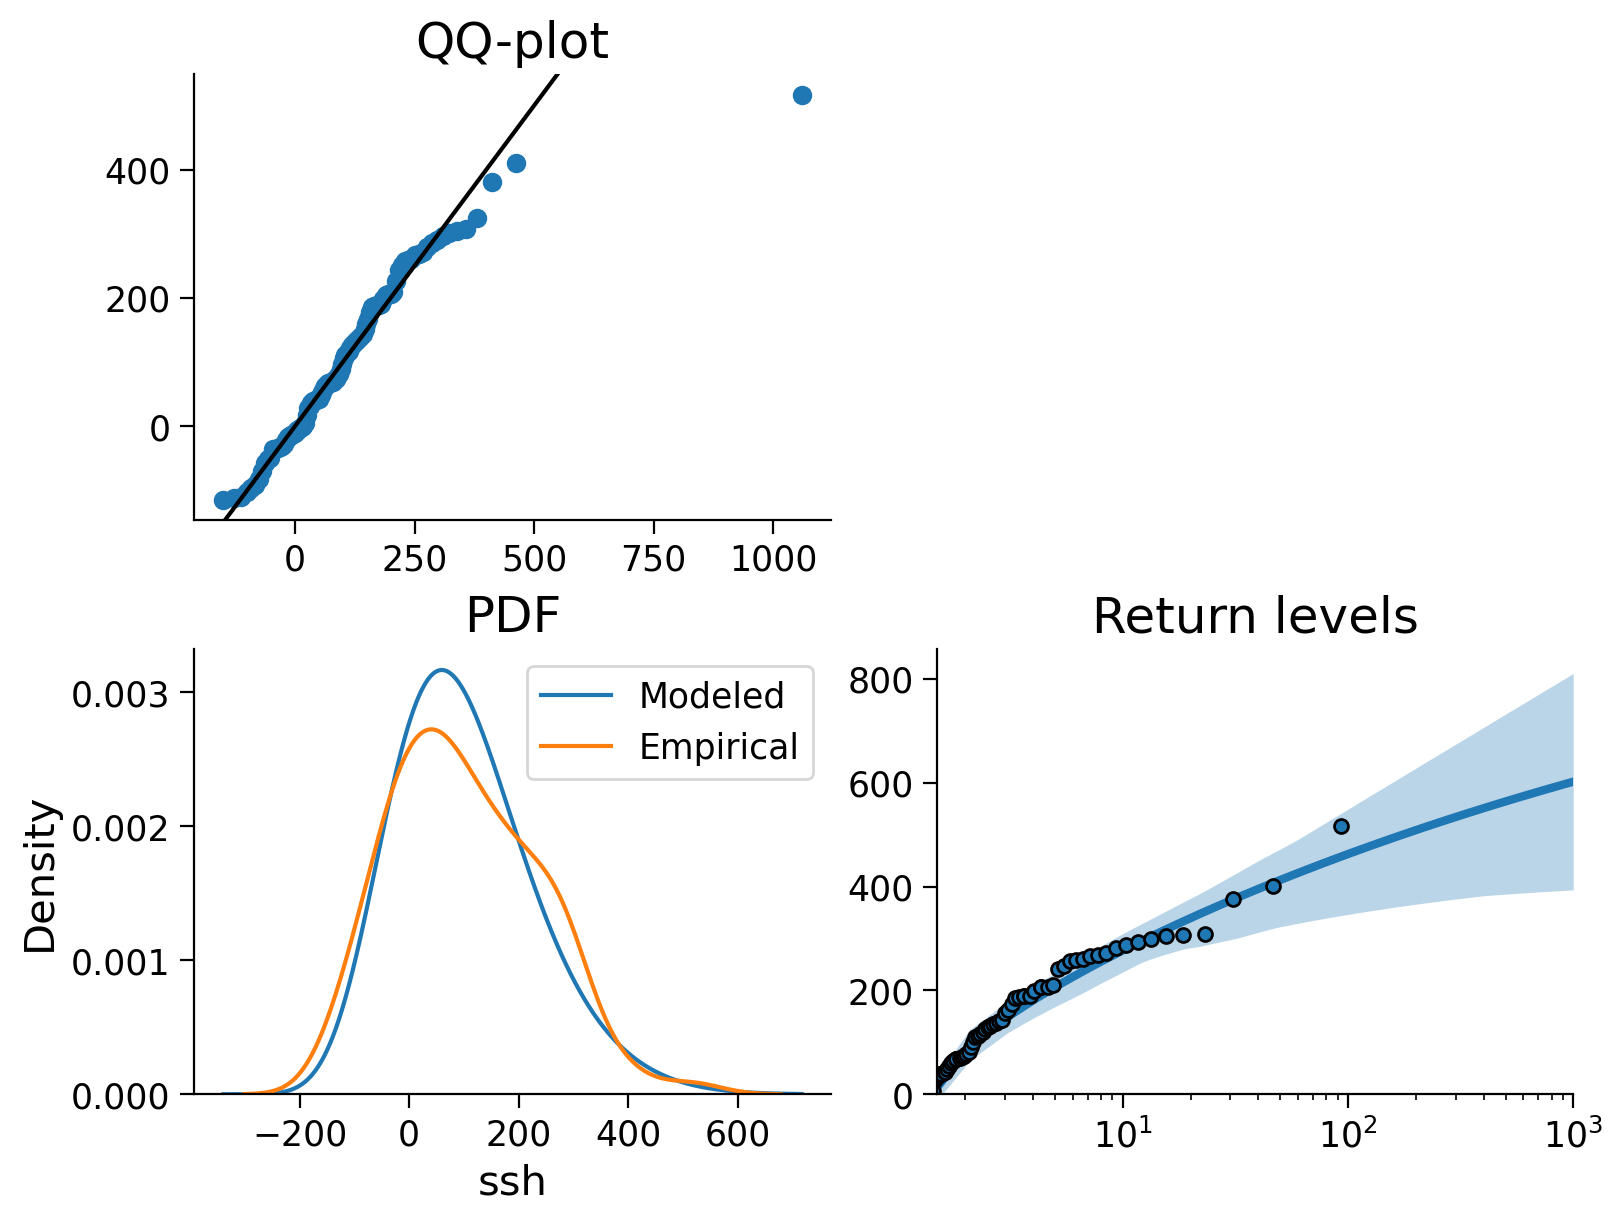

In [12]:
fig, axs = plt.subplots(2,2,constrained_layout=True)
ax = axs.flatten()

x = np.linspace(0,1,100)
ax[0].plot(
    gev.ppf(x, shape, loc=loc, scale=scale),
    np.quantile(data.ssh,x),
    'o')
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([min(xlim[0],ylim[0]),max(xlim[1],ylim[1])],[min(xlim[0],ylim[0]),max(xlim[1],ylim[1])],'k')

ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)


x = np.linspace(data.ssh.min()-200, data.ssh.max()+200, 1000)
ax[2].plot(x,gev.pdf(x, shape, loc=loc, scale=scale), label='Modeled')
sns.kdeplot(data.ssh,ax=ax[2],label='Empirical')
ax[2].legend()

gf.plot_return_levels(fit,ax=ax[3])
ax[3].set_xlim(1.5,1000)
ax[3].set_ylim(0,None)

ax[0].set_title('QQ-plot')
ax[2].set_title('PDF')
ax[3].set_title('Return levels')

ax[1].remove()

Use the function `estimate_return_level` to compute the 100-year return level:

In [13]:
print('100-year return level: %.2f' % gf.estimate_return_level_period(100,loc,scale,shape).mean())

100-year return level: 462.88



We have the option to make our GEV (Generalized Extreme Value) model non-stationary by introducing a time component to the GEV parameters. This means that the parameters will vary with time or can be dependent on other variables such as global air temperature. We call this **adding covariates** to parameters. 

The simplest way to implement a non-stationary GEV model is by adding a linear time component to the location parameter. Instead of a fixed location parameter like "100," it becomes a linear function of time (e.g., time * 1.05 + 80). This implies that the location parameter increases with time. We can incorporate this into our fitting process. The scipy GEV implementation does not support covariates. Therefore for this part we will use the package SDFC, using the `c_loc` option - to add a covariate ('c') to the location parameter ('loc').

In [14]:
# initialize a GEV distribution
law_ns = sd.GEV()
# fit the GEV to the data, while specifying that the location parameter ('loc') is meant to be a covariate ('_c') of the time axis (data.index)
law_ns.fit(data.ssh.values, c_loc = np.arange(data.index.size))

In [15]:
ef.print_law(law_ns)

+-----------+------------+------------------+
| GEV (mle) |    Type    |       coef       |
+===========+============+==================+
| loc       | Covariate  | [-103.002, 3.63] |
+-----------+------------+------------------+
| scale     | Stationary | 61.414           |
+-----------+------------+------------------+
| shape     | Stationary | 0.059            |
+-----------+------------+------------------+



Now the location parameter is of type "Covariate" (that is, it *covaries* with the array we provided to `c_loc`), and it now consists of *two* coefficients (intercept and slope) of the linear relationship between the location parameter and the provided array.

As observed, we established a linear relationship by associating the location parameter with a simple array of sequential numbers (1, 2, 3, 4, 5, 6, etc.). Alternatively, if we had used an exponential function of time (e.g., 1, 2, 4, 8, 16, by setting `c_loc = np.exp(np.arange(data.index.size)/data.index.size)`), we would have created an exponential relationship.

Similarly, squaring the array (`c_loc = np.arange(data.index.size)**2`) would have resulted in a quadratic relationship.

It's worth noting that various types of relationships can be employed, and this approach can be extended to multiple parameters by utilizing `c_scale` and `c_shape`. For instance, it's possible to establish a relationship with the global mean CO<sub>2</sub> concentration rather than solely relying on time, which could potentially enhance the fitting accuracy.

Since the location parameter is not time-dependent, we are unable to create a return level/return period plot as we did in the previous tutorials. This would require 93 separate plots, one for each year. However, there is an alternative approach that is visually appealing. We can calculate the level of the 100-year event over time and overlay it onto our SSH (Sea Surface Height) record. This is referred to as the "**effective return levels**".


Text(0.5, 0, 'Years')

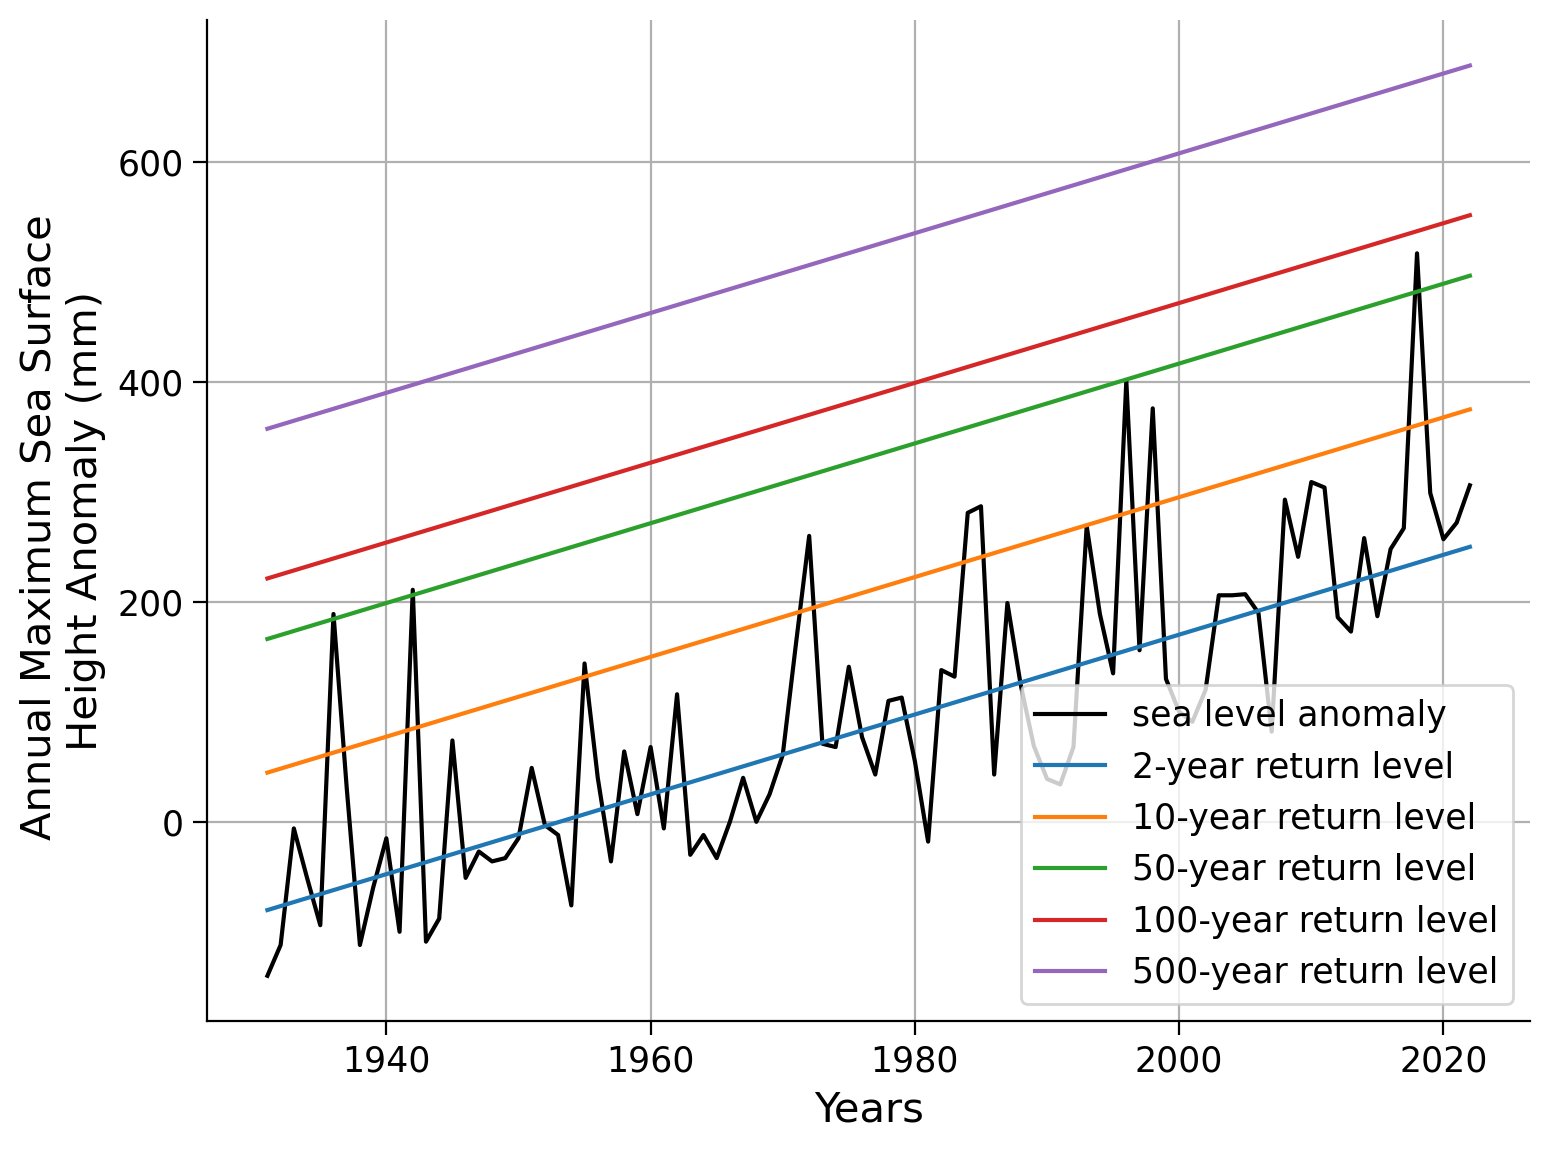

In [16]:
fig,ax=plt.subplots()
data.ssh.plot(c='k',label='sea level anomaly',ax=ax)
ax.plot(data.index,estimate_return_level(1-1/2,law_ns),label='2-year return level')
ax.plot(data.index,estimate_return_level(1-1/10,law_ns),label='10-year return level')
ax.plot(data.index,estimate_return_level(1-1/50,law_ns),label='50-year return level')
ax.plot(data.index,estimate_return_level(1-1/100,law_ns),label='100-year return level')
ax.plot(data.index,estimate_return_level(1-1/500,law_ns),label='500-year return level')
ax.legend()
ax.grid(True)
ax.set_ylabel('Annual Maximum Sea Surface \nHeight Anomaly (mm)')
ax.set_xlabel('Years')

You can evaluate the quality of your model fit by examining the AIC value. 
The [Akaike Information Criterion (AIC)]( https://en.wikipedia.org/wiki/Akaike_information_criterion) is useful to estimate how well the model fits the data, while preferring simpler models with fewer free parameters. A lower AIC value indicates a better fit. In the code provided below, a simple function is defined to calculate the AIC for a given fitted *model*.

In [17]:
def compute_aic(model):
    return 2 * len(model.coef_) + 2 * model.info_.mle_optim_result.fun

In [18]:
compute_aic(law_ns)

1062.4535266383766

For comparison, let's repeat the computation without the covariate by dropping the c_loc option. Then we can compute the AIC for the stationary model, and compare how well the model fits the data:

In [19]:
law_stat = sd.GEV()
law_stat.fit(data.ssh.values)

In [20]:
compute_aic(law_stat)

1161.2588604785979

You can see that AIC is lower for the model that has the location parameter as a *covariate* - this suggests this model fits the data better.

## **Coding Exercises 1** 

Scale and/or shape as function of time
You have seen above how to make the location parameter a function of time, by providing the keyword `c_loc` to the `fit()` function.
1. Now repeat this procedure, making scale, shape, or both parameters a function of time. To do this, you need to initialize a new GEV instance, call it e.g. `law_ns_scale = sd.GEV()` and then call the `.fit()` function similarly to before, but replace `c_loc` with `c_scale` and/or `c_shape`. Plot the effective return levels by providing your fitted model to the `estimate_return_level()` function, as done previously. Observe if the model fits the data better, worse, or remains the same.
2. Lastly, compute the AIC for your new fits. Compare the AIC values to determine if the expectation from the previous step is met.

In [ ]:
# initialize a GEV distribution
law_ns_scale = ...

# fit the GEV to the data, while specifying that the scale parameter ('scale') is meant to be a covariate ('_c') of the time axis (data.index)
law_ns_scale.fit(...)

# plot results
fig,ax=plt.subplots()
data.ssh.plot(c='k',ax=ax)
ax.plot(...,...,label='2-year return level')
ax.plot(...,...,label='10-year return level')
ax.plot(...,...,label='50-year return level')
ax.plot(...,...,label='100-year return level')
ax.plot(...,...,label='500-year return level')
ax.legend()
ax.grid(True)
ax.set_title('Scale as Function of Time')

Text(0.5, 1.0, 'Scale as Function of Time')

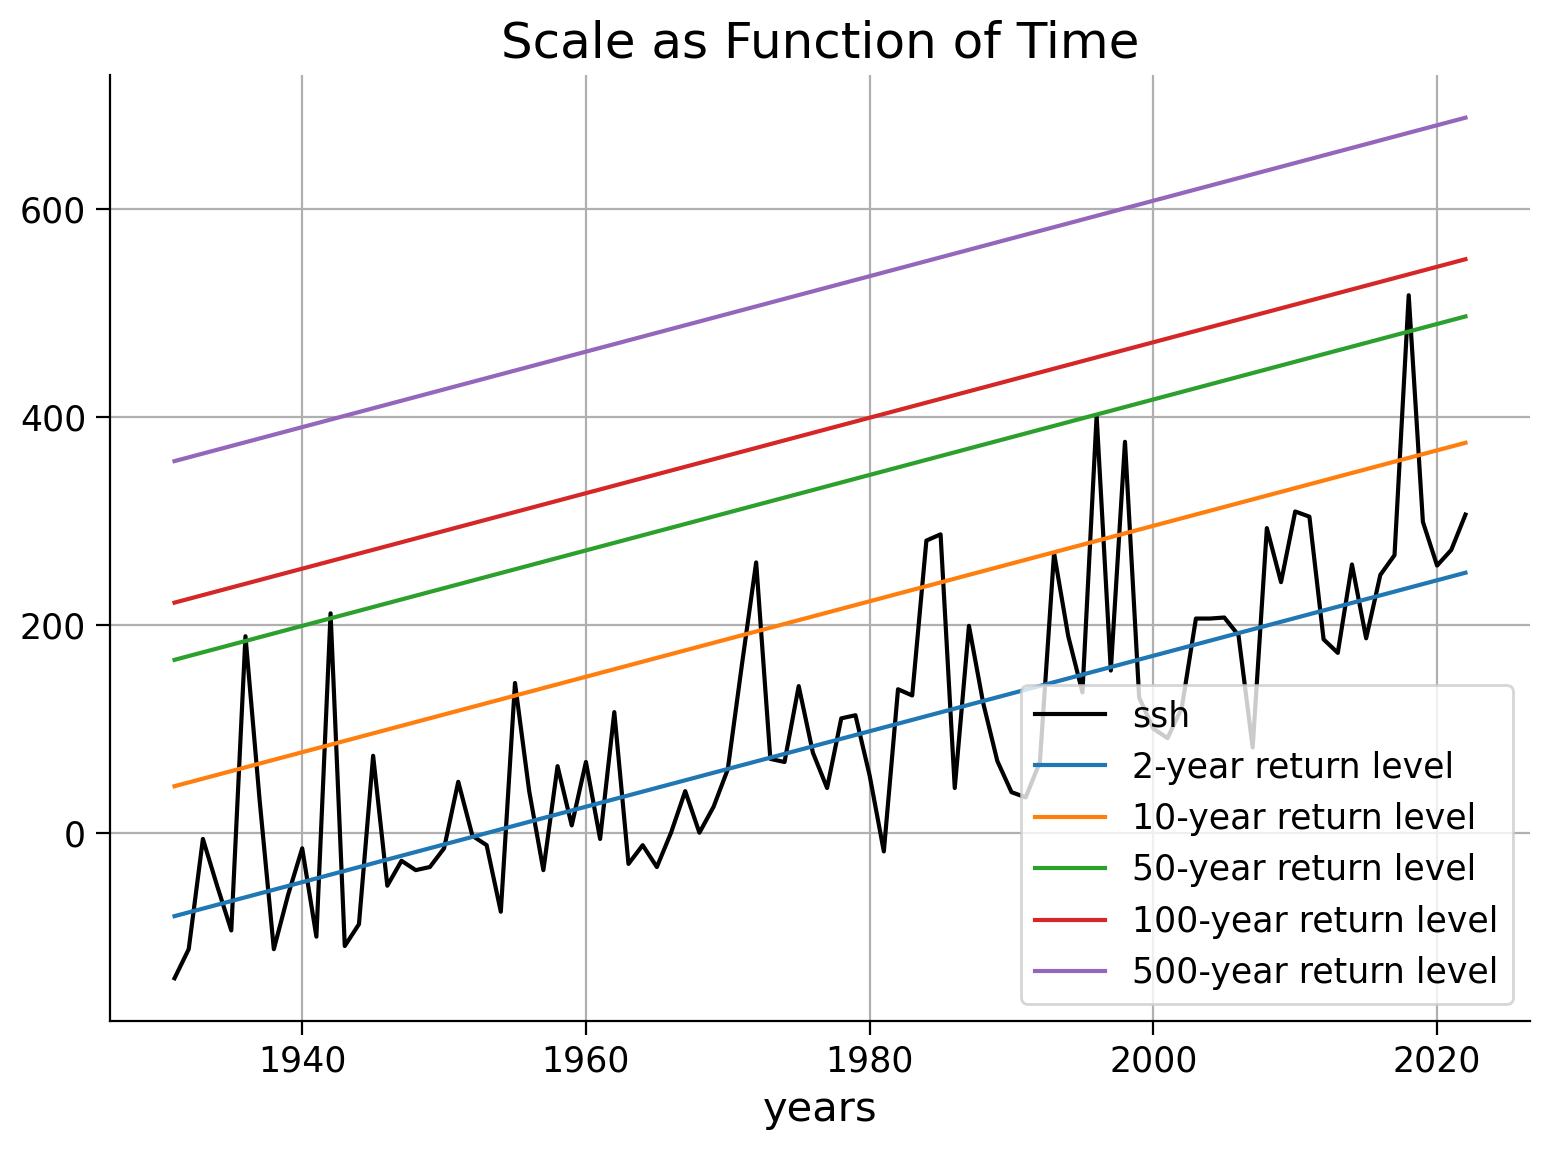

In [21]:
# to_remove solution

# initialize a GEV distribution
law_ns_scale = sd.GEV()

# fit the GEV to the data, while specifying that the scale parameter ('scale') is meant to be a covariate ('_c') of the time axis (data.index)
law_ns_scale.fit(data.ssh.values, c_scale = np.arange(data.index.size))

# plot results
fig,ax=plt.subplots()
data.ssh.plot(c='k',ax=ax)
ax.plot(data.index,estimate_return_level(1-1/2,law_ns),label='2-year return level')
ax.plot(data.index,estimate_return_level(1-1/10,law_ns),label='10-year return level')
ax.plot(data.index,estimate_return_level(1-1/50,law_ns),label='50-year return level')
ax.plot(data.index,estimate_return_level(1-1/100,law_ns),label='100-year return level')
ax.plot(data.index,estimate_return_level(1-1/500,law_ns),label='500-year return level')
ax.legend()
ax.grid(True)
ax.set_title('Scale as Function of Time')


In [ ]:
# initialize a GEV distribution
law_ns_shape = ...

# fit the GEV to the data, while specifying that the shape parameter ('shape') is meant to be a covariate ('_c') of the time axis (data.index)
law_ns_shape.fit(...)

# plot results
fig,ax=plt.subplots()
data.ssh.plot(c='k',ax=ax)
ax.plot(...,...,label='2-year return level')
ax.plot(...,...,label='10-year return level')
ax.plot(...,...,label='50-year return level')
ax.plot(...,...,label='100-year return level')
ax.plot(...,...,label='500-year return level')
ax.legend()
ax.grid(True)
ax.set_title('Scale as Function of Time')

Text(0.5, 1.0, 'Scale as Function of Time')

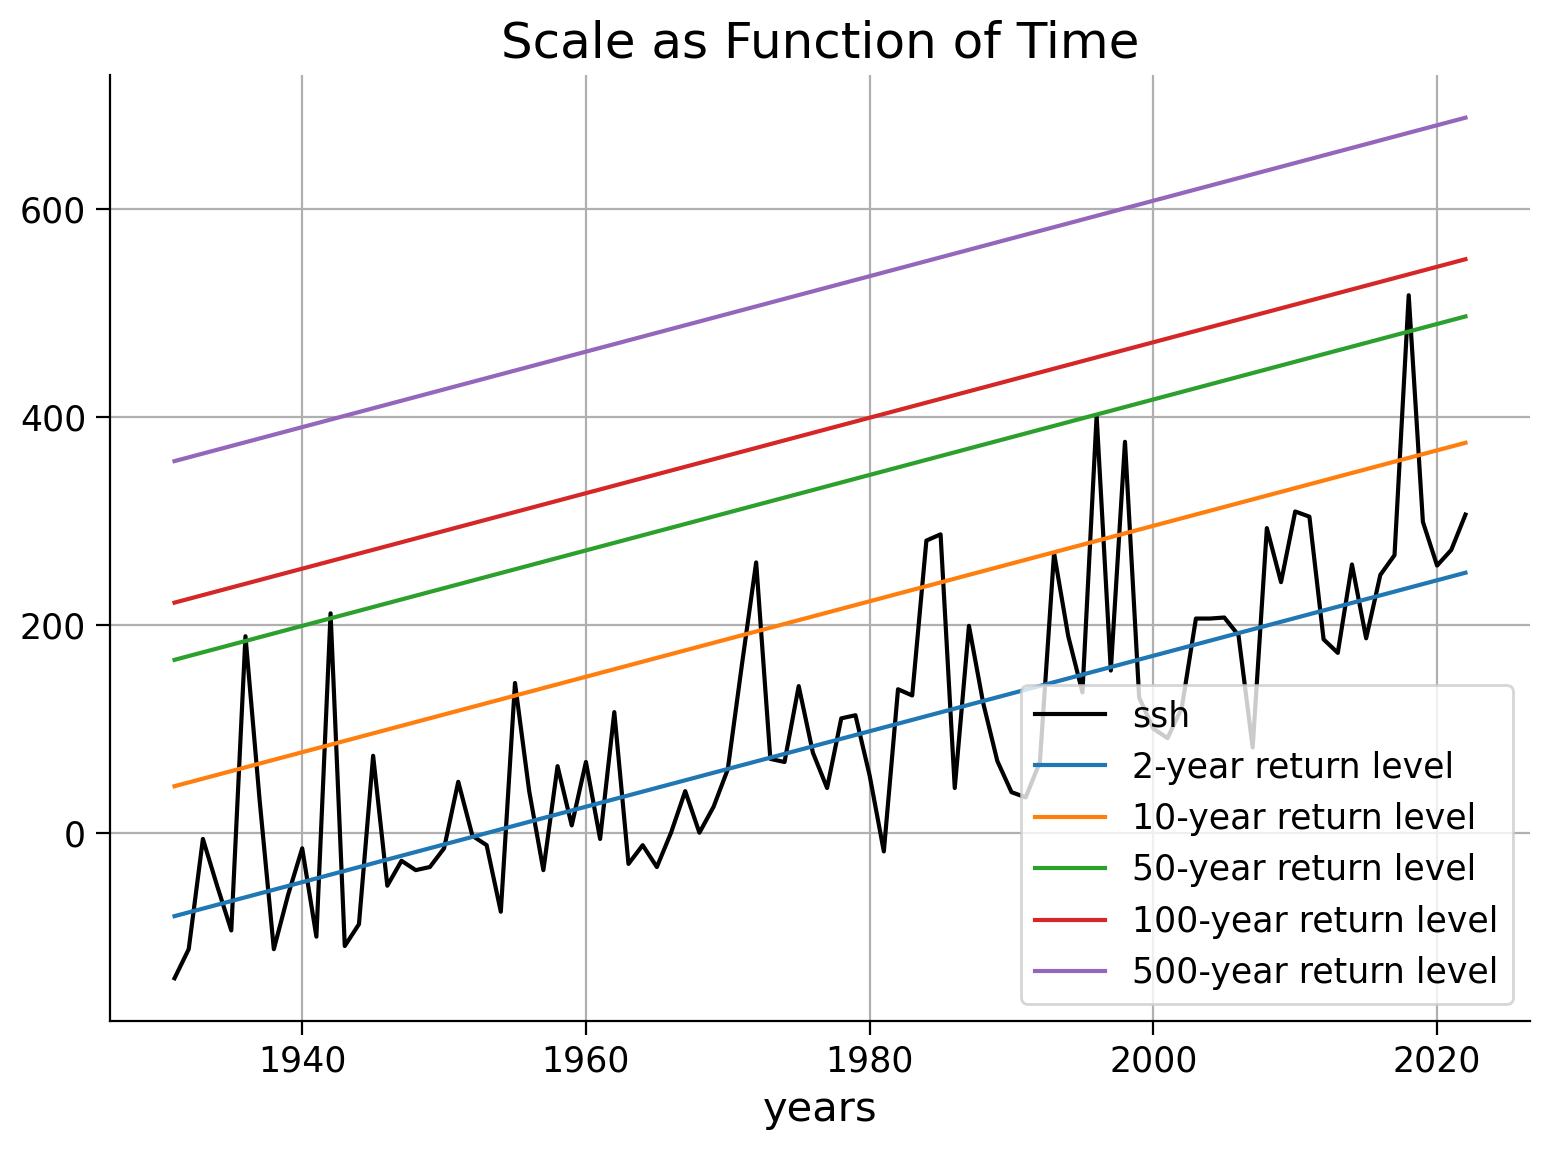

In [22]:
# to_remove solution

# initialize a GEV distribution
law_ns_shape = sd.GEV()

# fit the GEV to the data, while specifying that the shape parameter ('shape') is meant to be a covariate ('_c') of the time axis (data.index)
law_ns_shape.fit(data.ssh.values, c_shape = np.arange(data.index.size))

# plot results
fig,ax=plt.subplots()
data.ssh.plot(c='k',ax=ax)
ax.plot(data.index,estimate_return_level(1-1/2,law_ns),label='2-year return level')
ax.plot(data.index,estimate_return_level(1-1/10,law_ns),label='10-year return level')
ax.plot(data.index,estimate_return_level(1-1/50,law_ns),label='50-year return level')
ax.plot(data.index,estimate_return_level(1-1/100,law_ns),label='100-year return level')
ax.plot(data.index,estimate_return_level(1-1/500,law_ns),label='500-year return level')
ax.legend()
ax.grid(True)
ax.set_title('Scale as Function of Time')

In [ ]:
# initialize a GEV distribution
law_ns_loc_scale = ...

# fit the GEV to the data using c_loc and c_scale
law_ns_loc_scale.fit(...)

# plot results
fig,ax=plt.subplots()
data.ssh.plot(c='k',ax=ax)
ax.plot(...,...,label='2-year return level')
ax.plot(...,...,label='10-year return level')
ax.plot(...,...,label='50-year return level')
ax.plot(...,...,label='100-year return level')
ax.plot(...,...,label='500-year return level')
ax.legend()
ax.grid(True)
ax.set_title('Scale as Function of Time')

Text(0.5, 1.0, 'Scale as Function of Time')

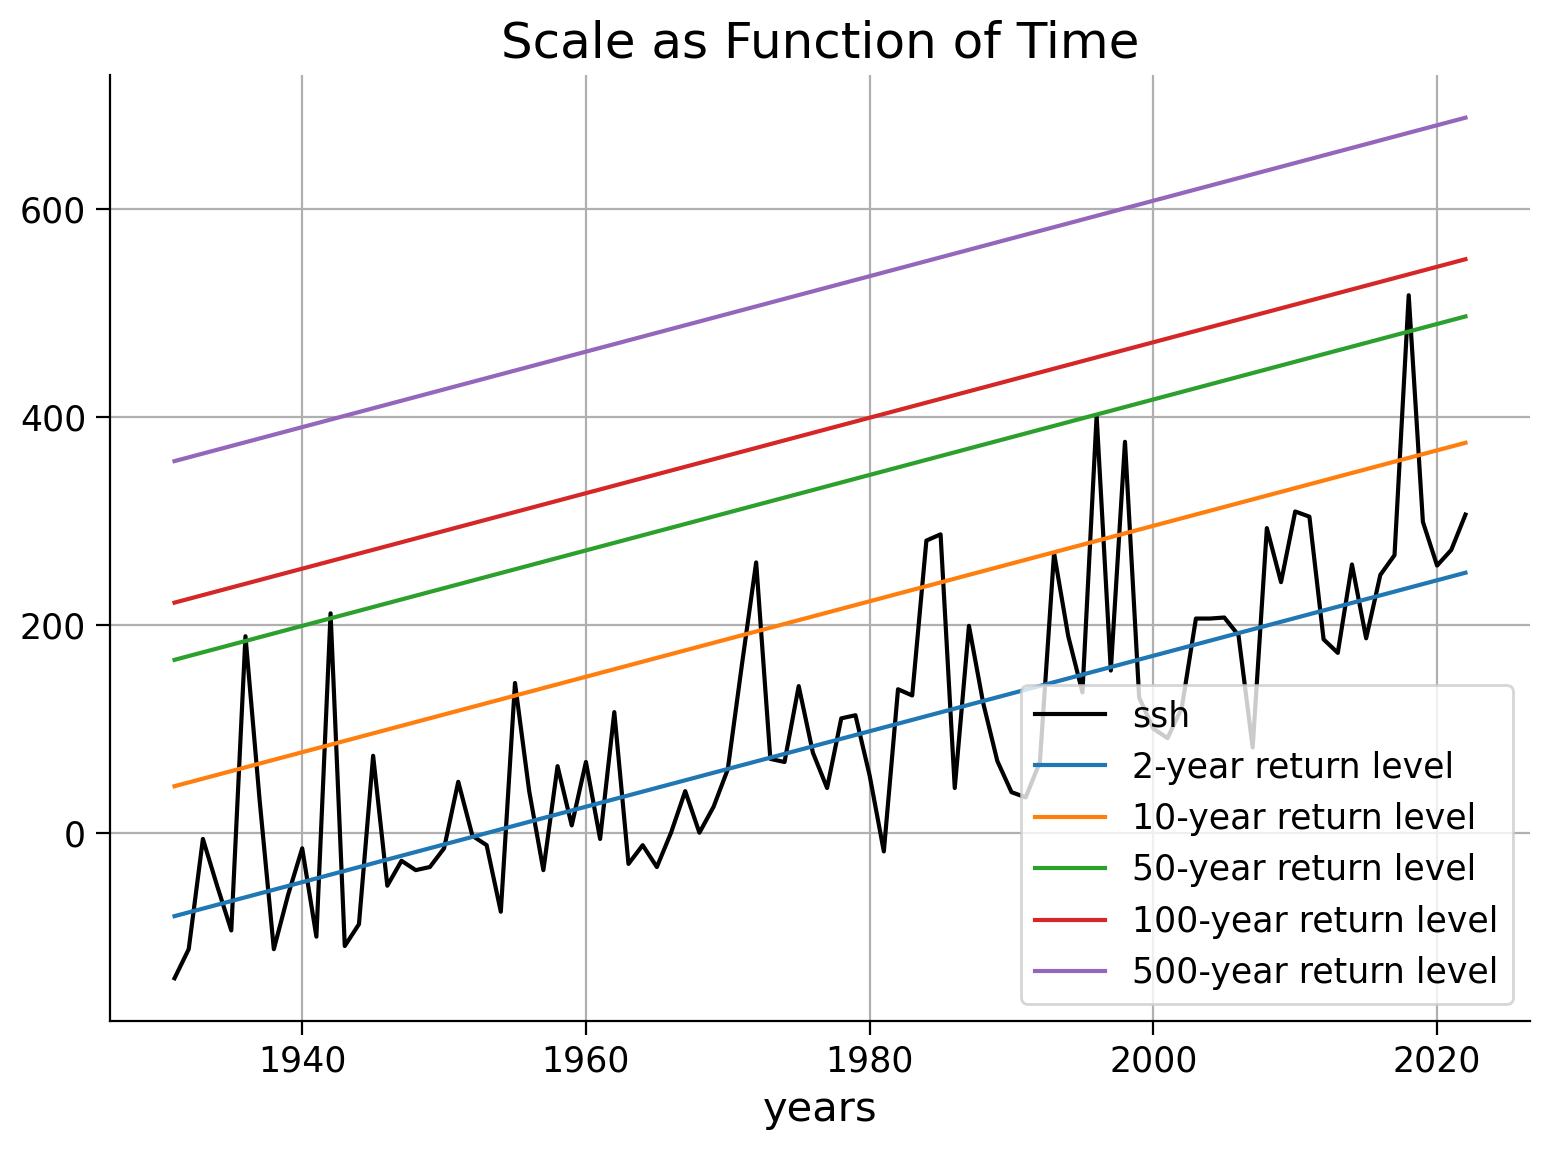

In [23]:
# to_remove solution

# initialize a GEV distribution
law_ns_loc_scale = sd.GEV()

# fit the GEV to the data using c_loc and c_scale
law_ns_loc_scale.fit(data.ssh.values, c_loc = np.arange(data.index.size), c_scale = np.arange(data.index.size))

# plot results
fig,ax=plt.subplots()
data.ssh.plot(c='k',ax=ax)
ax.plot(data.index,estimate_return_level(1-1/2,law_ns),label='2-year return level')
ax.plot(data.index,estimate_return_level(1-1/10,law_ns),label='10-year return level')
ax.plot(data.index,estimate_return_level(1-1/50,law_ns),label='50-year return level')
ax.plot(data.index,estimate_return_level(1-1/100,law_ns),label='100-year return level')
ax.plot(data.index,estimate_return_level(1-1/500,law_ns),label='500-year return level')
ax.legend()
ax.grid(True)
ax.set_title('Scale as Function of Time')

In [ ]:
aics = pd.Series(
    index = ['Location','Scale','Shape','Location and Scale'],
    data  = [
        ...,
        ...,
        ...,
        ...
    ]
    )

aics

In [24]:
# to_remove solution

aics = pd.Series(
    index = ['Location','Scale','Shape','Location and Scale'],
    data  = [
        compute_aic(law_ns), 
        compute_aic(law_ns_scale), 
        compute_aic(law_ns_shape), 
        compute_aic(law_ns_loc_scale)
    ]
    )

aics

Location              1062.453527
Scale                 1157.801560
Shape                 1161.219576
Location and Scale    1061.982856
dtype: float64

# **Summary**

In this tutorial, you adapted the GEV model to better fit non-stationary sea surface height data from Washington DC. You learned how to:

- Modify the GEV distribution to accommodate a time-dependent parameter, enabling non-stationarity.
- Compare different models based on their time-dependent parameters.
- Calculate effective return levels with the non-stationary GEV model.
- Assessed the fit of the model using the Akaike Information Criterion (AIC).

# **Resources**

Original data from this tutorial can be found [here](https://climexp.knmi.nl/getsealev.cgi?id=someone@somewhere&WMO=360&STATION=WASHINGTON_DC&extraargs=). Note the data used in this tutorial were preprocessed to extract the annual maximum values.